## learning-AI101 : California housing price regression (DL)
### 캘리포니아 주택 시세 데이터를 Dense layer struction과 CNN을 통한 regression 수행

<br>

- **임규연 (lky473736)**
- 2024.08.10. ~ 2024.08.11.에 문서 작성
- **kaggle** : https://www.kaggle.com/datasets/camnugent/california-housing-prices
- **data abstract** : This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow'. It serves as an excellent introduction to implementing machine learning algorithms because it requires rudimentary data cleaning, has an easily understandable list of variables and sits at an optimal size between being to toyish and too cumbersome. The data contains information from the 1990 California census. So although it may not help you with predicting current housing prices like the Zillow Zestimate dataset, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.

------

### <mark>Attention!</mark>

본 문서부터 DL에 plaidml-keras를 이용한 GPU 가속화를 진행한다. 
- 참고 : https://www.facebook.com/groups/KerasKorea/permalink/3077728298909781/

현재 local computer의 사양은 아래와 같다.

- CPU : 2.6 GHz 6코어 Intel Core i7
- 외장 GPU : Radeon Pro 560X 4 GB
- RAM : 32GB 2400 MHz DDR4

위와 같은 사양으로 여태껏 가속화를 안하고 하염없이 fitting이 완료되기만 기다린 예전의 나에게 박수를 보낸다. 하지만, **ML에서는 앞으로도 줄곧, 하염없이 기다려야 한다.** 그 이유는 scikit-learn의 내부 구조가 CPU에 최적화되어 있으며, 이는 추후에도 지원하지 않을 계획이라고 공식 문서에서 언급되어 있다. (https://scikit-learn.org/stable/faq.html#will-you-add-gpu-support)

In [1]:
import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

----
## <span id='dl'><mark>DL</mark></span>

deep learning으로 California housing price를 regression한다. 목차는 아래와 같다.

- **1. 간단한 데이터 분석 및 데이터 전처리**
- **2. deep learning 모델을 적용하여 regression**
    - **SGDRegressor를 이용한 regression 수행**
        - 여기서 Polynormial set과 normal set의 score를 비교한 후, 앞으로 이용할 dataset을 결정한다.
    - **2-1** : ANN
    - **2-2** : DNN
    - **2-3** : CNN

In [2]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2024-08-12 23:08:02.603026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


-----

### 1. 데이터 분석, 시각화 및 전처리
- 데이터 로드 및 필요한 정보, 기초통계량을 get한다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- cell 순서는 아래와 같다.
    - (1) 데이터 읽기 및 head 파악, dataframe에 대한 전처리
    - (2) 데이터 info (결측치 파악), 데이터 크기
    - (3) 데이터 기초통계량 확인
    - (4) heatmap 
    - (5) feature, input data split
    - (6) train set, test set, validation set split 
    - (7) input data : apply PolynormialFeature 
    - (8) scaling (z-score normalization)

In [3]:
# (1) 데이터 읽기 및 head 파악 및 dataframe에 대한 전처리

df = pd.read_csv ('data/california_house_prices.csv')
print (df.columns)

df = df.drop('Unnamed: 0', axis=1)
df.head()

Index(['Unnamed: 0', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
       'Population', 'AveOccup', 'Latitude', 'Longitude', 'PRICE'],
      dtype='object')


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
# (2) data info, data shape

print ("shape : ", df.shape)
df.info()

shape :  (20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   PRICE       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
# (3) 데이터 기초통계량 확인

df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


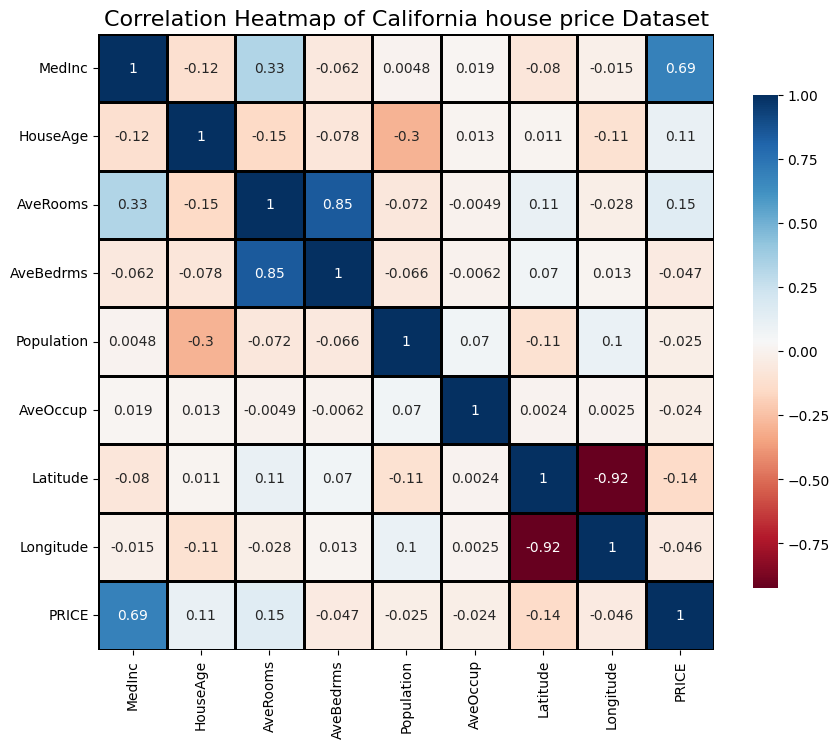

In [6]:
# (4) heatmap

correlation_matrix = df.corr() 
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of California house price Dataset', fontsize=16)
plt.show()

In [7]:
# (5) feature, input data split

california_input = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
       'Population', 'AveOccup', 'Latitude', 'Longitude']].to_numpy()
california_target = df['PRICE'].to_numpy()

california_input.shape, california_target.shape

((20640, 8), (20640,))

In [8]:
# (6) train set, test set, validation set split

X_train, X_test, y_train, y_test = train_test_split(california_input, california_target,
                                                   test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=0.2)

In [9]:
# (7) input data : PolynormialFeature 

from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2)
X_train_poly = poly_transformer.fit_transform(X_train)
X_test_poly = poly_transformer.transform(X_test)
X_val_poly = poly_transformer.transform(X_val)

print (poly_transformer.degree, poly_transformer.get_feature_names_out)

2 <bound method PolynomialFeatures.get_feature_names_out of PolynomialFeatures()>


In [10]:
# (8) scaling (z-score normalization)

z_score_transformer = StandardScaler()
X_train_scaled = z_score_transformer.fit_transform(X_train)
X_test_scaled = z_score_transformer.transform(X_test)
X_val_scaled = z_score_transformer.transform(X_val)

z_score_transformer = StandardScaler()
X_train_poly_scaled = z_score_transformer.fit_transform(X_train_poly)
X_test_poly_scaled = z_score_transformer.transform(X_test_poly)
X_val_poly_scaled = z_score_transformer.transform(X_val_poly)

-------

### 2. SGDRegressor 통한 ML에서의 확률적 경사 하강법 적용
deep learning을 하기 전, deep learning의 weight 및 bias 조정법인 **SGD (Stochastic Gradient Descent)** 를 scikit-learn으로 구현해본다. parameter는 random search를 통하여 최적화할 것이며, 자세한 조정범위는 아래에 서술한다.
- loss function : 오차제곱법 사용 (squared_error)
- max_iter : 3~100 (randint)

rs1에서는 normal set, rs2에서는 polynormial set을 학습하여 score를 비교한다.

In [11]:
# random search를 통한 hyperparameter tuning

from sklearn.linear_model import SGDRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param = {
    'max_iter' : randint(3, 100),        # 최대 반복 횟수
    'alpha' : uniform(1e-6, 1e-2),       # 정규화 강도
    'eta0' : uniform(1e-4, 1e-1)         # 초기 학습률
}

sr = SGDRegressor(loss='squared_error', penalty='l2')

# normal set
rs1 = RandomizedSearchCV(sr, param, n_iter=50, cv=5, n_jobs=-1)
rs1.fit (X_train_scaled, y_train)

# polynormial set
rs2 = RandomizedSearchCV(sr, param, n_iter=50, cv=5, n_jobs=-1)
rs2.fit (X_train_poly_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration re

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration re

RandomizedSearchCV(cv=5, estimator=SGDRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13e0b19d0>,
                                        'eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x143db0350>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x143f427d0>})

In [12]:
# best score, best model, train score, test score

sr1 = rs1.best_estimator_
print ("***** normal set score *****")
print ("best score : ", rs1.best_score_)
print ("best estimator (model) : ", sr1)

sr1_score = [sr1.score(X_train_scaled, y_train), sr1.score(X_test_scaled, y_test)]
print (f"train score, test score : {sr1_score}")

print()

sr2 = rs2.best_estimator_
print ("***** polynormial set score *****")
print ("best score : ", rs2.best_score_)
print ("best estimator (model) : ", sr2)

sr2_score = [sr2.score(X_train_poly_scaled, y_train), sr2.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {sr2_score}")

***** normal set score *****
best score :  0.5680123926665385
best estimator (model) :  SGDRegressor(alpha=0.005703369608954494, eta0=0.0010947237344940408,
             max_iter=19)
train score, test score : [0.5924611616862989, 0.612918809353959]

***** polynormial set score *****
best score :  -33764309.590607055
best estimator (model) :  SGDRegressor(alpha=0.006755613995662615, eta0=0.00147200775677081, max_iter=48)
train score, test score : [-4235606.057143035, -2062964.5204555937]


둘 다 점수가 참 희안하다. 그에 대한 원인을 탐구해보자.

- 일단은, **normal set이 polynormial set보다 점수가 높다.**
    - 그러한 이유는 아래를 꼽을 수 있다.
        - (1) feature가 너무 많은데, 그 feature의 pattern을 찾을 정도로 data의 분포가 충분치 못할 수도 있다.
        - (2) 모델의 복잡성이 많은 feature에 비해 턱없이 부족해서 이런 결과가 나타났을 수도 있다.
- 둘이 굳이 비교할 필요가 없는데, polynormial set score만 보아도 이 비교가 필요 없음을 알 수 있을 것이다.

따라서, **추후 실험은 normal set으로만 진행한다.**

-------

### 3.  ANN (fully connected)
- hidden layer를 구성하지 않고, 입력층과 출력층만 존재하는 인공신경망을 struction할 것이다.
- 기존 train set에서 validation set을 하나 더 구성하였고, 추후 evaluation에 사용할 예정이다.
- 출력층의 activation을 사용하지 않는다. (regression이기 때문에)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 9 (36.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


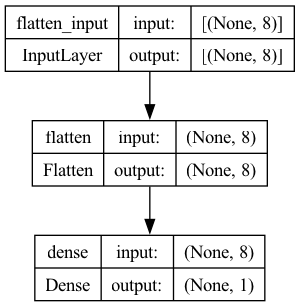

In [13]:
# modelling

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(8, )), 
    keras.layers.Dense(1)
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [14]:
# compile
# reference : https://dacon.io/forum/405791

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

만약 여기서 metrics로 'mape'를 설정하였다면 정말 큰 숫자가 나올 것이다. 경험담이다. 나왔다. mape는 0~100%의 범위를 가지는 비율로써, 0에 가까울 수록 오차가 없어 모델의 성능이 좋은 건데, mape를 사용하는 순간 비정상적으로 큰 비율이 출력된다. 원인은 다음과 같다.

- 모델이 너무 간단해서 그럴 수 있다고 생각한다.
- 애초에 flatten 층과 함께 parameter의 갯수가 현저히 적어서 이런 문제가 발생하는 것 같다.
- target이 0과 가깝게 scaling해놨기 때문에 그럴 것.

In [15]:
# fit

history = model.fit(X_train_scaled, y_train, epochs=100, 
                   validation_data=(X_val_scaled, y_val), verbose=True)

print (history.history)

Epoch 1/100
413/413 [==============================] - 1s 1ms/step - loss: 6.0985 - mae: 1.9145 - val_loss: 4.7128 - val_mae: 1.6706
Epoch 2/100
413/413 [==============================] - 0s 818us/step - loss: 3.8876 - mae: 1.5251 - val_loss: 2.9765 - val_mae: 1.3162
Epoch 3/100
413/413 [==============================] - 0s 840us/step - loss: 2.4787 - mae: 1.1975 - val_loss: 1.8854 - val_mae: 1.0203
Epoch 4/100
413/413 [==============================] - 0s 828us/step - loss: 1.6054 - mae: 0.9317 - val_loss: 1.2325 - val_mae: 0.7896
Epoch 5/100
413/413 [==============================] - 0s 807us/step - loss: 1.0936 - mae: 0.7365 - val_loss: 0.8674 - val_mae: 0.6411
Epoch 6/100
413/413 [==============================] - 0s 850us/step - loss: 0.8148 - mae: 0.6204 - val_loss: 0.6822 - val_mae: 0.5688
Epoch 7/100
413/413 [==============================] - 0s 873us/step - loss: 0.6747 - mae: 0.5684 - val_loss: 0.5980 - val_mae: 0.5422
Epoch 8/100
413/413 [==============================] - 0s

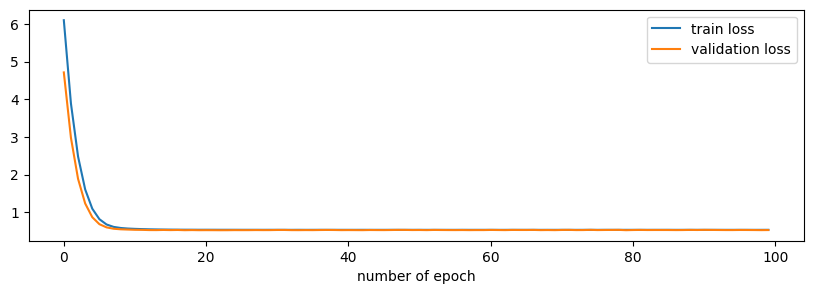

In [16]:
# loss 시각화

plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.legend (['train loss', 'validation loss'])
plt.show() 

기가 막힌 loss 곡선의 개형을 보아라. deep learning의 힘이다. 거시적으로 볼 때는 위와 같은 figure를 확인할 수 있다. **하지만, 일부분만 확대하여 들여다보면 어떨까?**

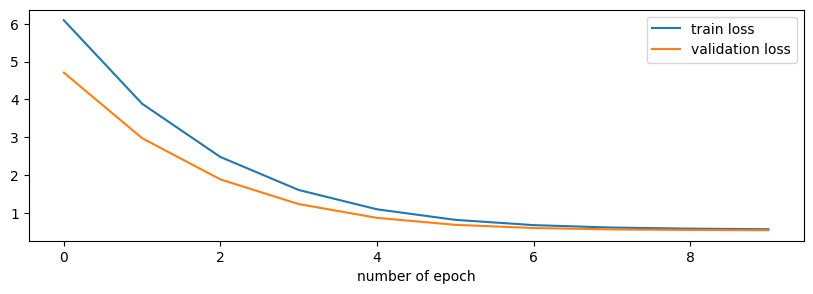

In [17]:
# loss 중 일부를 시각화 : 0~10

plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'][0:10])        
plt.plot(history.history['val_loss'][0:10]) 
plt.xlabel("number of epoch")   
plt.legend(['train loss', 'validation loss'])

일부분만 확대해서 들여다 보아도 **overfitting을 매우 잘 억제하고 있음이 보인다.**

In [18]:
# evaluate

model.evaluate(X_val_scaled, y_val)

104/104 [==============================] - 0s 912us/step - loss: 0.5266 - mae: 0.5362


[0.5265740752220154, 0.5362092852592468]

-------

### 4. DNN 
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - parameter는 최소한 15000개 이상으로 증폭, 각 node의 activation은 relu 사용
    - epoch는 100으로 고정
- 아래와 같이 experiment할 예정이다.
    - optimizer는 **적응형 학습율 optimizer인 adam을 사용한다.**
    - validation loss 감소를 위하여 **dropout 층을 추가 후, callback으로 early stopping을 도입**한다.
        - patiences는 5로 한다.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 64)                576       
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (

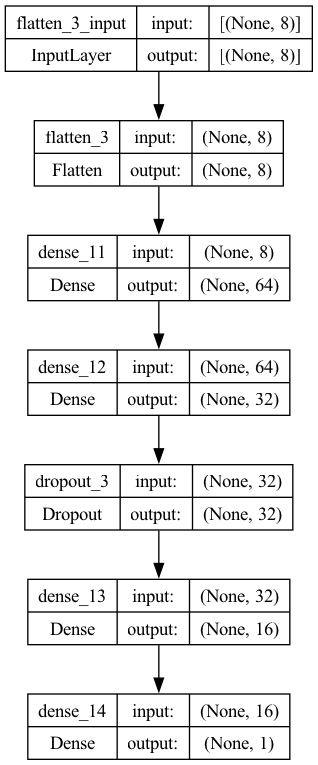

In [25]:
# modelling DNN

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(8, )), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [26]:
# compile

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, 
              loss='mse', metrics=['mae'])

In [27]:
# callback 설정 및 fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val),
                    callbacks=early_stopping_cb, verbose=True)

Epoch 1/100
413/413 [==============================] - 1s 2ms/step - loss: 1.0564 - mae: 0.7205 - val_loss: 0.4465 - val_mae: 0.4772
Epoch 2/100
413/413 [==============================] - 0s 1ms/step - loss: 0.5465 - mae: 0.5262 - val_loss: 0.4388 - val_mae: 0.4591
Epoch 3/100
413/413 [==============================] - 0s 1ms/step - loss: 0.4725 - mae: 0.4917 - val_loss: 0.3910 - val_mae: 0.4468
Epoch 4/100
413/413 [==============================] - 0s 1ms/step - loss: 0.4340 - mae: 0.4711 - val_loss: 0.3803 - val_mae: 0.4388
Epoch 5/100
413/413 [==============================] - 0s 1ms/step - loss: 0.4169 - mae: 0.4579 - val_loss: 0.3821 - val_mae: 0.4215
Epoch 6/100
413/413 [==============================] - 0s 1ms/step - loss: 0.4044 - mae: 0.4534 - val_loss: 0.3609 - val_mae: 0.4119
Epoch 7/100
413/413 [==============================] - 0s 1ms/step - loss: 0.3891 - mae: 0.4426 - val_loss: 0.3537 - val_mae: 0.4163
Epoch 8/100
413/413 [==============================] - 0s 1ms/step - 

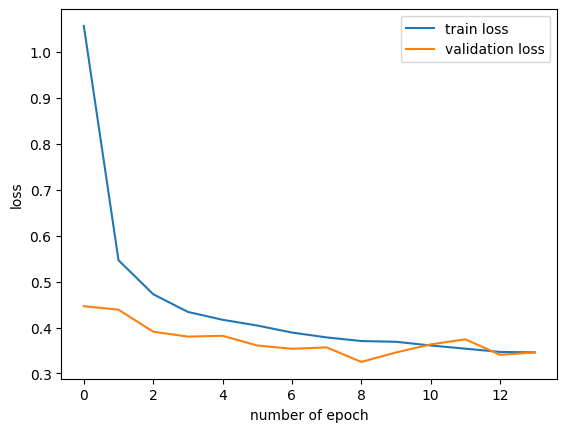

In [28]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [29]:
# evaluate

model.evaluate(X_val_scaled, y_val)

104/104 [==============================] - 0s 891us/step - loss: 0.3252 - mae: 0.4045


[0.32517269253730774, 0.40451547503471375]

-------

### 5.  CNN (2D)
- convolution을 통하여 중요한 feature만 도드라지게 하여 학습을 진행한다.
- 일단은, CNN을 여기에 적용하기엔 부적합할 수 있다. 하지만 진행해보자면...
    - 3차원 tensor로 전환하여 Conv2D layer로 convolution을 시행할 수 있을 것 같다. 아래와 같이 전환한다.
        - 배치 크기 : row의 갯수
        - 세로 : 1 (관계형 데이터 csv이기 때문에 한 row를 기준으로)
        - 가로 : feature의 갯수 (col의 갯수)
        - 채널 : 1 (데이터를 단일 채널이라고 가정)
    - 전환 후 CNN 2d를 적용하여 main feature extraction 후 pooling을 진행한다.
    - Conv, pooling을 2번 반복 후 dense layer를 두어 regression한다.
        - 중간에 dropout 층을 배치하여 overfitting을 막고 학습에 신중하도록 한다.
- overfitting을 막기 위하여, DNN에서 했던 것과 같이 early stopping 콜백을 설치하려고 했으나, 충분한 학습을 한 후 loss 추이를 확인하기 위하여 콜백을 두지 않겠다.

In [31]:
# X_train_scaled, X_test_scaled, X_val_scaled 데이터를 3차원 tensor로 전환한다.

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1], 1))
X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1], 1))

In [32]:
# shape 확인

X_train_cnn.shape, X_test_cnn.shape, X_val_cnn.shape

((13209, 1, 8, 1), (4128, 1, 8, 1), (3303, 1, 8, 1))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 8, 1)]         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 8, 32)          128       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 4, 16)          1552      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 2, 16)          0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 32)                0   

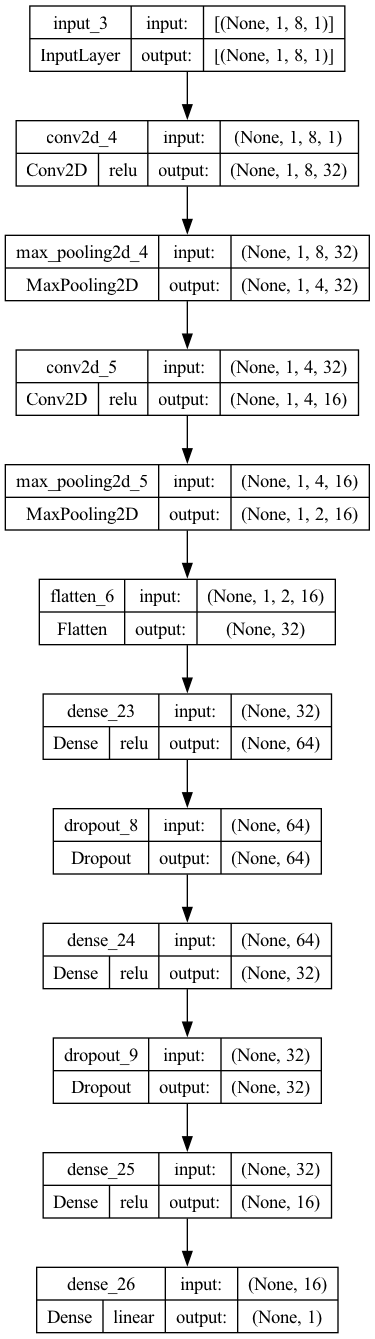

In [39]:
# modelling (functional API 방식)

input_layer = keras.Input(shape=(1, 8, 1))
conv_1 = keras.layers.Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same')(input_layer)
pooling_1 = keras.layers.MaxPooling2D((1, 2))(conv_1)
conv_2 = keras.layers.Conv2D(16, kernel_size=(1, 3), activation='relu', padding='same')(pooling_1)
pooling_2 = keras.layers.MaxPooling2D((1, 2))(conv_2)
flatten = keras.layers.Flatten()(pooling_2)
dense_1 = keras.layers.Dense(64, activation='relu') (flatten)
dropout_1 = keras.layers.Dropout(0.2) (dense_1)
dense_2 = keras.layers.Dense(32, activation='relu') (dropout_1)
dropout_2 = keras.layers.Dropout(0.2) (dense_2)
dense_3 = keras.layers.Dense(16, activation='relu') (dropout_2)
output_layer = keras.layers.Dense(1, activation='linear') (dense_3)

# model = keras.Model(
#     input_layer,
#     conv_1,
#     pooling_1,
#     conv_2,
#     pooling_2,
#     flatten,
#     dense_1,
#     dropout_1,
#     dense_2,
#     dropout_2,
#     dense_3,
#     output_layer
# )

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [40]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, loss='mse', metrics=['mae'])

In [41]:
# fit (충분한 학습을 하기 위하여 조기 종료 콜백을 넣지 않아보겠다)

# early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, 
#                                                 restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, epochs=100, 
                    validation_data=(X_val_cnn, y_val),
                    # callbacks=early_stopping_cb, 
                    verbose=True)

Epoch 1/100
413/413 [==============================] - 2s 3ms/step - loss: 1.1275 - mae: 0.7110 - val_loss: 0.4829 - val_mae: 0.4804
Epoch 2/100
413/413 [==============================] - 1s 2ms/step - loss: 0.5670 - mae: 0.5333 - val_loss: 0.4233 - val_mae: 0.4510
Epoch 3/100
413/413 [==============================] - 1s 2ms/step - loss: 0.4900 - mae: 0.4985 - val_loss: 0.3831 - val_mae: 0.4368
Epoch 4/100
413/413 [==============================] - 1s 2ms/step - loss: 0.4448 - mae: 0.4752 - val_loss: 0.3621 - val_mae: 0.4213
Epoch 5/100
413/413 [==============================] - 1s 2ms/step - loss: 0.4266 - mae: 0.4633 - val_loss: 0.3779 - val_mae: 0.4214
Epoch 6/100
413/413 [==============================] - 1s 2ms/step - loss: 0.4115 - mae: 0.4551 - val_loss: 0.3509 - val_mae: 0.4046
Epoch 7/100
413/413 [==============================] - 1s 2ms/step - loss: 0.3993 - mae: 0.4485 - val_loss: 0.3590 - val_mae: 0.4069
Epoch 8/100
413/413 [==============================] - 1s 2ms/step - 

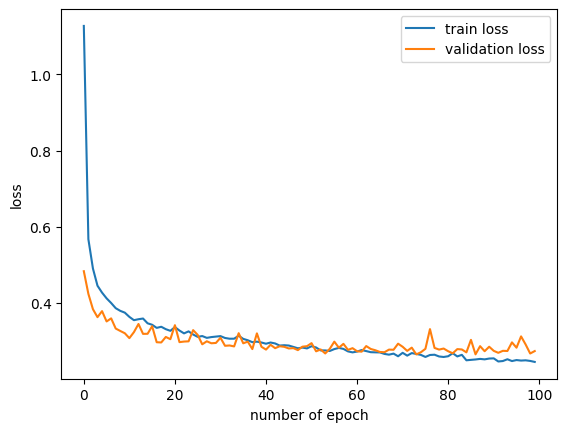

In [42]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 